<a href="https://colab.research.google.com/github/nosignal00/researchSpace/blob/main/MultiAccountStrategy/backTestingWithChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,sys
import datetime as dt

base_dir = os.getcwd()
nb_path = base_dir + '/drive/MyDrive/Colab_rel'
sys.path.append(nb_path)
sys.path.append(nb_path + '/lib/python3.9/site-packages')

In [2]:
# !chmod 755 /content/drive/MyDrive/Colab_rel/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc

In [ ]:
# !pip install --prefix=$nb_path yfinance

In [ ]:
# !pip install --prefix=$nb_path pulp

In [2]:
import yfinance as yf
import pytz

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import math
from pulp import *
import pdb


In [3]:
yf.pdr_override()
tz = pytz.timezone("America/New_York")
end = tz.localize(dt.datetime.now())
start = tz.localize(dt.datetime(2021, 11,10))

In [4]:
dfQQQ = yf.download('QQQ',start, end)
dfQQQ.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,392.470001,395.359985,387.529999,389.510010,385.570312,54937400
2021-11-11,392.570007,392.750000,390.239990,390.589996,386.639435,32243000
2021-11-12,391.769989,395.250000,390.130005,394.700012,390.707825,34730600
2021-11-15,395.910004,396.239990,392.100006,394.609985,390.618713,33716900
2021-11-16,393.859985,397.929993,393.660004,397.420013,393.400299,27872900


In [5]:
dfTQQQ = yf.download('TQQQ',start, end)
dfTQQQ.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,81.360001,83.199997,78.250000,79.535004,78.665733,96976800
2021-11-11,81.375000,81.495003,79.949997,80.180000,79.303688,57719000
2021-11-12,80.904999,83.035004,79.875000,82.724998,81.820869,63820400
2021-11-15,83.455002,83.654999,81.044998,82.699997,81.796135,69729200
2021-11-16,82.144997,84.705002,82.029999,84.410004,83.487457,51590800


In [281]:
def percent_change_strategy(base_col, n_pct, value_range, stride, use_first_row_as_base_price=True):
    base_price = None
    last_range_index = None
    range_size = (value_range[1] - value_range[0]) / stride
    
    def strategy(row):
        prices = row.values
        nonlocal base_price
        nonlocal value_range
        nonlocal range_size
        nonlocal last_range_index
        if base_price is None:
            base_price = prices[base_col]
        if last_range_index is None:
            last_range_index = 0
        signal = 0
        
        if use_first_row_as_base_price:
          changePct = ((prices[base_col] - base_price) / base_price) * 100
          range_index = int((changePct - value_range[0]) // range_size)
          if (range_index - last_range_index > 0)  and range_index != 0:
            signal = 2
            last_range_index = range_index
          elif range_index - last_range_index < 0:
            signal = 1
            last_range_index = range_index

        else:
          if prices[base_col] >= base_price * (1 + n_pct/100):
            signal = 2  # Buy signal
            base_price = prices[base_col] 
            # When signal is changed, base price is changed  
          elif prices[base_col] <= base_price * (1 - n_pct/100):
            signal = 1  # Sell signal
            base_price = prices[base_col] 
            # When signal is changed, base price is changed
        
        return signal
    
    return strategy


In [282]:
def distribute_cost_by_ratio(total_capital, unit_costs, assigned_ratio):
    num_tasks = len(unit_costs)
    # Define the LP problem
    prob = LpProblem("Even_Cost_Distribution", LpMinimize)

    # Define the decision variables (positive integers)
    x = LpVariable.dicts("x", range(num_tasks), lowBound=0, cat='Integer')

    # Define the objective function (minimize the maximum gap)
    prob += lpSum([1 for i in range(num_tasks)])

    # Define the constraint for total cost within 90% to 100% of total capital
    total_cost = lpSum([unit_costs[i] * x[i] for i in range(num_tasks)])
    prob += total_cost >= 0.9 * total_capital
    prob += total_cost <= 0.99 * total_capital

    # Define the constraints (assigned ratio)
    cum_ratio = 0
    for i in range(len(assigned_ratio)):
        assigned_cost = assigned_ratio[i] / sum(assigned_ratio) * total_capital
        cum_ratio += assigned_ratio[i]
        prob += x[i] * unit_costs[i] >= assigned_cost
        if i == len(assigned_ratio) - 1:
            prob += lpSum([x[j] for j in range(i+1, num_tasks)]) == 0
        else:
            next_assigned_cost = cum_ratio / sum(assigned_ratio) * total_capital
            prob += x[i] * unit_costs[i] <= next_assigned_cost

    # Solve the LP problem
    prob.solve()

    # Print the solution
    # print("Evenly distributed costs:")
    # for i in range(num_tasks):
    #     budget = round(x[i].value(), 2)
    #     cost = round(budget * unit_costs[i], 2)
    #     print(f"Task {i+1}: budget = {budget}, cost = {cost}")
    return [int(x[i].value()) for i in range(num_tasks)]

In [283]:
def calculate_shares_to_buy(row, cash, ratio):
    # stock_prices = row.values
    stock_prices = row
    shares_to_buy = distribute_cost_by_ratio(cash,stock_prices,ratio)
    return shares_to_buy

In [284]:
def cash_balance_closure(initial_cash, name_of_first_row,ratio_in):
    initial_cash_balance = None
    prev_shares_to_buy = None
    prev_signal = None
    ratio = ratio_in
    def cash_balance_apply(row):
        nonlocal initial_cash_balance
        nonlocal prev_shares_to_buy
        nonlocal prev_signal
        nonlocal ratio
        if row.name != name_of_first_row :
          # Get the previous row's cash balance and signal value
          prev_cash_balance = initial_cash_balance
          shares_to_buy = prev_shares_to_buy
          signal = prev_signal

          if signal == 1:
              # Calculate shares to buy for each stock based on previous cash balance
              stock_prices = row.values[:2]  # only stock price columns
              shares_to_buy = calculate_shares_to_buy(stock_prices, prev_cash_balance, ratio)

          # Calculate the new cash balance based on the shares bought and current stock prices
          stock_prices = row.values[:2]  # only stock price columns
          new_cash_balance = sum(shares_to_buy * stock_prices)

          # Update the initial cash balance for the next row
          initial_cash_balance = new_cash_balance
          prev_shares_to_buy = shares_to_buy
          prev_signal = row['signal']

        else :
          # Set the cash balance to the initial cash balance for the first row
          stock_prices = row.values[:2]  # only stock price columns
          new_cash_balance = initial_cash
          prev_shares_to_buy = calculate_shares_to_buy(stock_prices, new_cash_balance, ratio)
          prev_signal = row['signal']

        # Return the updated cash balance for the current row
        return pd.Series([new_cash_balance, prev_shares_to_buy])

    # Return the inner function
    return cash_balance_apply


In [285]:
# 2021 11 15 부터 해보자
# 이 때부터 대세 하락이 시작되었다.

In [286]:
basePriceDf = pd.merge(left = dfQQQ["Adj Close"], right = dfTQQQ["Adj Close"], left_index=True, right_index=True)

In [287]:
strategy = percent_change_strategy(0, 10,[0,100],10,True)
basePriceDf['signal'] = basePriceDf.apply(strategy, axis=1)

In [293]:
basePriceDf.loc[['2022-01-27','2022-01-28']]

,Adj Close_x,Adj Close_y,signal
Date,,,
2022-01-27,338.081207,50.996487,0
2022-01-28,348.686493,55.753910,2


<Axes: xlabel='Date'>

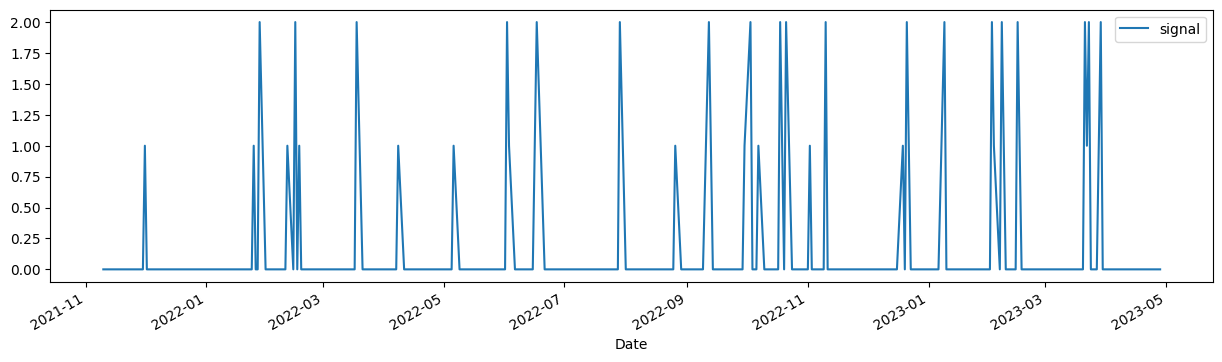

In [289]:
basePriceDf.plot(y='signal',figsize = (15,4))

In [290]:
basePriceDf[basePriceDf['signal']==2]

,Adj Close_x,Adj Close_y,signal
Date,,,
2022-01-28,348.686493,55.753910,2
2022-02-15,352.978210,56.673748,2
2022-03-18,348.379242,52.588886,2
2022-06-02,311.982910,34.518570,2
2022-06-17,272.595581,22.422232,2
2022-07-29,313.656464,32.995396,2
2022-09-12,308.963440,30.591957,2
2022-10-03,272.454926,20.434200,2
2022-10-18,270.412964,19.563818,2


In [251]:
initial_cash_balance = 15000
cash_balance_apply = cash_balance_closure(initial_cash_balance,basePriceDf.index[0],[1,1])
basePriceDf[['cash_balance','shares_to_buy']] = basePriceDf.apply(cash_balance_apply, axis=1)

In [252]:
basePriceDf.head(10)

,Adj Close_x,Adj Close_y,signal,cash_balance,shares_to_buy
Date,,,,,
2021-11-10,385.570312,78.665733,0,15000.000000,"[19, 95]"
2021-11-11,386.639435,79.303688,0,14879.999626,"[19, 95]"
2021-11-12,390.707825,81.820869,0,15196.431267,"[19, 95]"
2021-11-15,390.618713,81.796135,0,15192.388374,"[19, 95]"
2021-11-16,393.400299,83.487457,0,15405.914124,"[19, 95]"
2021-11-17,393.608246,83.586365,0,15419.261322,"[19, 95]"
2021-11-18,397.686493,86.143112,0,15739.639023,"[19, 95]"
2021-11-19,399.903870,87.601990,0,15920.362549,"[19, 95]"
2021-11-22,395.261292,84.565544,0,15543.691231,"[19, 95]"


In [253]:
def row_product(row):
    return pd.Series([row['Adj Close_x'] * row['shares_to_buy'][0] , row['Adj Close_y'] * row['shares_to_buy'][1]])

In [254]:
basePriceDf[['balance_x','balance_y']] = basePriceDf.apply(row_product, axis=1)

In [255]:
basePriceDf.head(10)

,Adj Close_x,Adj Close_y,signal,cash_balance,shares_to_buy,balance_x,balance_y
Date,,,,,,,
2021-11-10,385.570312,78.665733,0,15000.000000,"[19, 95]",7325.835938,7473.244667
2021-11-11,386.639435,79.303688,0,14879.999626,"[19, 95]",7346.149261,7533.850365
2021-11-12,390.707825,81.820869,0,15196.431267,"[19, 95]",7423.448669,7772.982597
2021-11-15,390.618713,81.796135,0,15192.388374,"[19, 95]",7421.755554,7770.632820
2021-11-16,393.400299,83.487457,0,15405.914124,"[19, 95]",7474.605682,7931.308441
2021-11-17,393.608246,83.586365,0,15419.261322,"[19, 95]",7478.556671,7940.704651
2021-11-18,397.686493,86.143112,0,15739.639023,"[19, 95]",7556.043365,8183.595657
2021-11-19,399.903870,87.601990,0,15920.362549,"[19, 95]",7598.173523,8322.189026
2021-11-22,395.261292,84.565544,0,15543.691231,"[19, 95]",7509.964539,8033.726692


<Axes: xlabel='Date'>

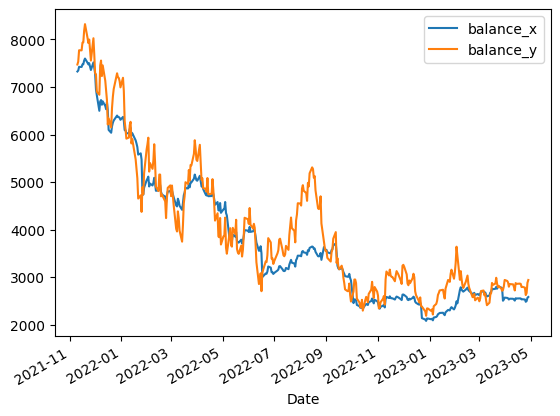

In [256]:
basePriceDf.plot(y=['balance_x', 'balance_y'], kind='line')

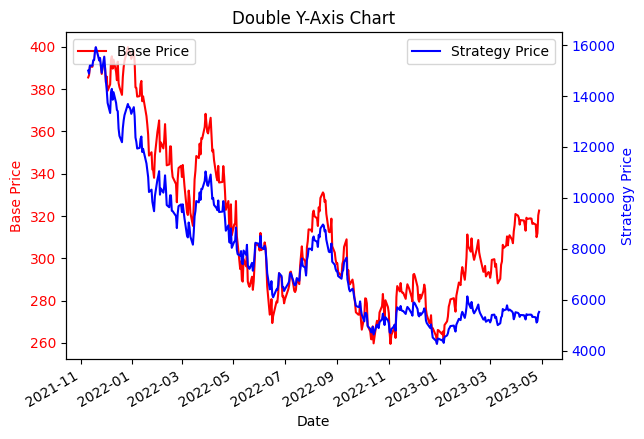

In [258]:
# create a line chart with two y-axes
ax = basePriceDf.plot(y='Adj Close_x', color='red', kind='line', label='Base Price')
ax.set_xlabel('Date')
ax.set_ylabel('Base Price', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.legend(loc='upper left')

ax2 = ax.twinx()
basePriceDf.plot(y='cash_balance', color='blue', kind='line', ax=ax2, label='Strategy Price')
ax2.set_ylabel('Strategy Price')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Double Y-Axis Chart')

# display the chart
plt.show()

In [259]:
(basePriceDf.iloc[-1,0] - basePriceDf.iloc[0,0]) / basePriceDf.iloc[0,0]

-0.16342107495998218

In [260]:
(basePriceDf.iloc[-1,3] - basePriceDf.iloc[0,3]) / basePriceDf.iloc[0,3]

-0.6321013346354166

## 뭔가 이상함
1. 일단 가진 돈을 다 활용하지 않아서 일 수도 있으니 그 방향으로 코드를 바꿔보자.
  - 현재는 바로 이전 Row의 돈만을 활용하는 거니 계속 시간이 지날 수록 돈이 쪼그라 드는 거 같음
2. 또 떨어질 때 %와 오를 때 %를 다르게 해서 트리거를 걸 수 있도록 하자.

### TEST SECTION

In [ ]:
dates = pd.date_range('2022-01-01', periods=10)
prices = pd.DataFrame({
    'stock1': [10, 12, 15, 14, 13, 12, 13, 15, 16, 17],
    'stock2': [20, 22, 25, 24, 23, 22, 23, 25, 26, 27]
}, index=dates)

In [ ]:
def printRowname(row):
  return row.name

In [ ]:
prices['name'] = prices.apply(printRowname, axis=1)

In [ ]:
prices.loc[:,'name']

2022-01-01   2022-01-01
2022-01-02   2022-01-02
2022-01-03   2022-01-03
2022-01-04   2022-01-04
2022-01-05   2022-01-05
2022-01-06   2022-01-06
2022-01-07   2022-01-07
2022-01-08   2022-01-08
2022-01-09   2022-01-09
2022-01-10   2022-01-10
Freq: D, Name: name, dtype: datetime64[ns]

In [ ]:
strategy = percent_change_strategy(0, 10)
signals = prices.apply(strategy, axis=0)

In [ ]:
import pandas as pd
import numpy as np

# create a sample DataFrame
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]})

# define the function to apply
def sqrt_func(x):
    return np.sqrt(x)

# apply the function to multiple columns
df[['A', 'B', 'C']] = df[['A', 'B', 'C']].apply(sqrt_func, axis=1)

# print the resulting DataFrame
print(df)

          A         B         C
0  1.000000  2.000000  2.645751
1  1.414214  2.236068  2.828427
2  1.732051  2.449490  3.000000


In [ ]:
def trading_decision(signal, cash_balance, num_shares, stock_price):
    if signal == 2 and cash_balance > 0:
        num_shares_to_buy = cash_balance // stock_price
        return buy(stock_price, cash_balance, num_shares_to_buy)
    elif signal == 1 and num_shares > 0:
        return sell(stock_price, cash_balance, num_shares)
    else:
        return cash_balance, num_shares


In [ ]:
def sell(stock_price, cash_balance, num_shares):
    cash_balance += stock_price * num_shares
    num_shares = 0
    return cash_balance, num_shares


In [ ]:
def buy(stock_price, cash_balance, num_shares):
    if stock_price * num_shares > cash_balance:
        raise ValueError("Insufficient funds to buy shares.")
    cash_balance -= stock_price * num_shares
    return cash_balance, num_shares


In [ ]:
def moving_average_crossover_strategy(prices, short_window=50, long_window=200):
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = prices['close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = prices['close'].rolling(window=long_window, min_periods=1, center=False).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   
    signals['positions'] = signals['signal'].diff()
    return signals


In [ ]:
def distribute_cost_by_ratio(total_capital, unit_costs, assigned_ratio):
    num_tasks = len(unit_costs)
    # Define the LP problem
    prob = LpProblem("Even_Cost_Distribution", LpMinimize)

    # Define the decision variables (positive integers)
    x = LpVariable.dicts("x", range(num_tasks), lowBound=0, cat='Integer')

    # Define the objective function (minimize the maximum gap)
    prob += lpSum([1 for i in range(num_tasks)])

    # Define the constraint for total cost within 90% to 100% of total capital
    total_cost = lpSum([unit_costs[i] * x[i] for i in range(num_tasks)])
    prob += total_cost >= 0.9 * total_capital
    prob += total_cost <= 0.99 * total_capital

    # Define the constraints (assigned ratio)
    cum_ratio = 0
    for i in range(len(assigned_ratio)):
        assigned_cost = assigned_ratio[i] / sum(assigned_ratio) * total_capital
        cum_ratio += assigned_ratio[i]
        prob += x[i] * unit_costs[i] >= assigned_cost
        if i == len(assigned_ratio) - 1:
            prob += lpSum([x[j] for j in range(i+1, num_tasks)]) == 0
        else:
            next_assigned_cost = cum_ratio / sum(assigned_ratio) * total_capital
            prob += x[i] * unit_costs[i] <= next_assigned_cost

    # Solve the LP problem
    prob.solve()

    # Print the solution
    # print("Evenly distributed costs:")
    # for i in range(num_tasks):
    #     budget = round(x[i].value(), 2)
    #     cost = round(budget * unit_costs[i], 2)
    #     print(f"Task {i+1}: budget = {budget}, cost = {cost}")
    return [int(x[i].value()) for i in range(num_tasks)]


In [170]:
a = 200
base_price = 120
n_pct = 5

(a - base_price) % (base_price * n_pct/100) < a % (base_price * n_pct/100)

False

In [171]:
a % (base_price * n_pct/100)

2.0

In [172]:
120 * 0.05

6.0

In [174]:
200%6

2